##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h2>Activation Heatmaps with tf.keras on Images</h2>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/activation_heatmaps.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/activation_heatmaps.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/activation_heatmaps.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<h3>Introduction</h3>

<h4>What is and Activation heatmap?</h4><p>An activation heatmap helps us to know what caused our model to predict the class of the image in order words the most important parts of the image that helps the model in classifying images</p>
 <p>Try to follow the comments in the Code to understand how it is being done.</p>

Importing all the needed libaries

In [1]:
%tensorflow_version 2.x
import matplotlib.image as mpimg 
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras import backend as Kbe
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as IMG
from skimage import io
%matplotlib inline

TensorFlow 2.x selected.


<h3>Getting the VGG16 model</h3>
<p>We will Load the VGG16 model from imagenet weights. Imagenet is a pretrained image classification model that comes with tf.keras but the weights are not bundled with it. The weights will be downloaded into our project when we run the cell.</p>

In [0]:
#This is the model that we will be using to predict the class of the image 
#and get the activation heatmap from the image
model = VGG16(weights = 'imagenet')

In [0]:
#this is to disable eager_execution
tf.compat.v1.disable_eager_execution()

In [0]:
#This will help us to show the images to the notebook
from google.colab.patches import cv2_imshow

<h3>Extracting our image from a url</h3>
<p>Here, we will be getting the images from their urls using a function that utilizes <code>skimage io.imread()</code> function to read the image and <code>cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)</code> to convert the image back to its original color because <code>io.imread</code> does not give the original color of the image. The differences in the color of the image will be seen because we will print it to the screen before converting it back to its original color</p>

In [0]:

#This function will simply help us get the images from the web url 
def url_to_image(url):
  #reading the image from the url
  read_img = io.imread(url)
  #print("This is the image read by io.imread()")
  #cv2_imshow(read_img)
  #converting the image to its original color
  image = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
  print("\nThis is the image converted to its original form")
  cv2_imshow(image)
  return image

<p>Now we will be calling our function and passing the url to the image which you want to use.</p>


This is the image converted to its original form


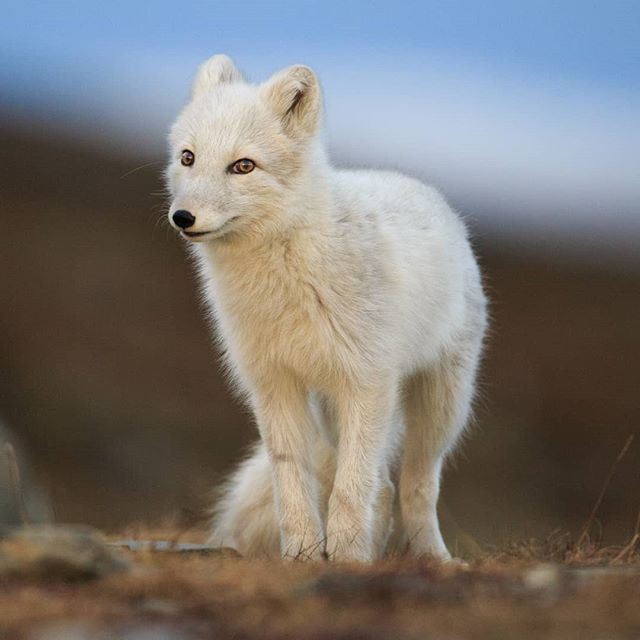

In [6]:
#Link to the image 
url = 'https://scontent-lht6-1.cdninstagram.com/v/t51.2885-15/sh0.08/e35/s640x640/67096206_152944595853833_7890601765204304502_n.jpg?_nc_ht=scontent-lht6-1.cdninstagram.com&_nc_cat=105&oh=462a420176ae50ee022b9144dbc25868&oe=5E747C2C&ig_cache_key=MjEwNDU5NjM0ODQ3MDMzODIzMQ%3D%3D.2'

#Converting the image from the url to an image for us to be able to work on
img = url_to_image(url)


<h3>Processing the image</h3>
<p>After getting our image, we need to convert it to numpy arrays preprocess it because <code>tf.keras</code> works on batches of images with size which is (size1, size2, channels). In order to do that, will will use <strong>VGG16</strong> <code>preprocess_input()</code> to make the numpy array be in the format that our model will work on </p>

In [0]:
#Here, we will convert the image to numpy array 
np_array = IMG.img_to_array(img)
#adding a dimension to the axis 0.
np_array = np.expand_dims(np_array, axis=0)

#Now the numpy array will be preprocessed using the VGG16 preprocessing function. 
#The reason why the image is preprocessed is because thats the way our model will need
process = preprocess_input(np_array)

#We are just passing the processed image to another variable to be used later on 
processed_img = process 


<h3>Greating a Prediction function</h3>
<p>This our prediction function that we are going to create will work on our preprocessed image which is in the form that our model needs in order to predict the class of the image and it will show us the top 3 classification of the image and the probability of the highest prediction that led to selected class for the image. let say our selected image was an Arctic_fox, three top predictions will be gotten from the image and the predicted class with the highest probability will be the selected class for that cat for example it could be an <ol> 
<li>Arctic_fox with accuracy 0.98</li> 
<li>White_wolf with accuracy 0.0</li>
<li>weasel with accuracy 0.0</li>
</ol>
 We see that <strong>Arctic_fox has the heighest accuracy so it will be selected class of the cat.</p>

In [0]:
#This function takes the processed image which is in numpy array and make prediction on it 
#to know the class of the image and a graph of the top predictions is ploted using the seaborn libary which we imported from the starting
def pedict(proc_img):
    #Here, we need to add number steps per batch size
    predict = model.predict(proc_img, steps=5)

    #After the predictions have been made, we are passing it to pandas DataFrame 
    #so tha we can use it to plot our prediction graph. A Data Frame is a two dimensional data structure
    predictions = pd.DataFrame(decode_predictions(predict, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    print('PREDICTION:',predictions.loc[0,'category'])
    frame = sns.barplot(x='probability',y='category',data=predictions,color="purple")
    sns.set_style(style='white')
    frame.grid(True)
    frame.spines["top"].set_visible(True)
    frame.spines["right"].set_visible(True)
    frame.spines["bottom"].set_visible(True)
    frame.spines["left"].set_visible(True)
    frame.set_title('Top 3 Predictions:')
    
    return predictions

<h3>Making predictions on the image and plotting a prediction graph</h3>
<p>Here we call our prediction function to predict the class of the image and show us the top three predictions from the image</p>

40960/35363 [==================================] - 0s 0us/step
PREDICTION: Arctic_fox


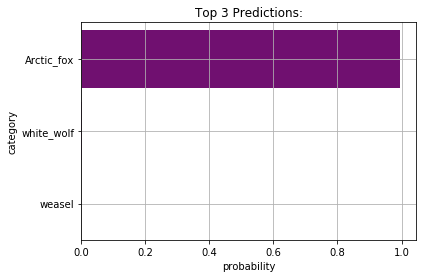

In [9]:
#Resizing the processed image because the size of the image is not what our model expects
my_img = tf.image.resize(processed_img, (224, 224))
pedections = pedict(my_img)

In [0]:
predict = model.predict(my_img, steps=5)

In [0]:
#getting the highest confidence value from our predicted image
np_argmax = np.argmax(predict[0])

output = model.output[:, np_argmax]

#Getting the last convolutional layer
conv_layer = model.get_layer('block5_conv3')

#getting the gradient  
gradient = Kbe.gradients(output, conv_layer.output)[0]

pooled_grad = Kbe.mean(gradient, axis=(0, 1, 2))

iterate = Kbe.function([model.input], [pooled_grad, conv_layer.output[0]])

#These are the values of these two quantities, as Numpy arrays 
grad_value, conv_layer_output_value = iterate([my_img])

#We will multiply each channel in the feature map array
for i in range(512):
  conv_layer_output_value[:, :, i] *= grad_value[i]

<h3>Generating the heatmap</h3>
<p>This are the next thing that we are going to do
<ol>
<li>We generate our heatmap from the image that is those places that caused our model to select a class for that image. This is important because it helps us to know how images are classified differently  </li>
<li>After generating our heatmap, we will convert it to RGB color so that we can apply it to the image to see the spots that the heatmaps were generated from</li>
<li>When our heatmap have been converted to RBG format, we add and intensity factor to it. The intensity factor gives us the color scheme of the image that is how visible we want the heatmaps on the image to be 
</li>
<li>Lastly we show the image that the heatmaps have been applied to</li>
</ol>
We will pass the different images that we will tested to different varaibles to store them temporaly in order to output or display it
</p>



This is the image converted to its original form


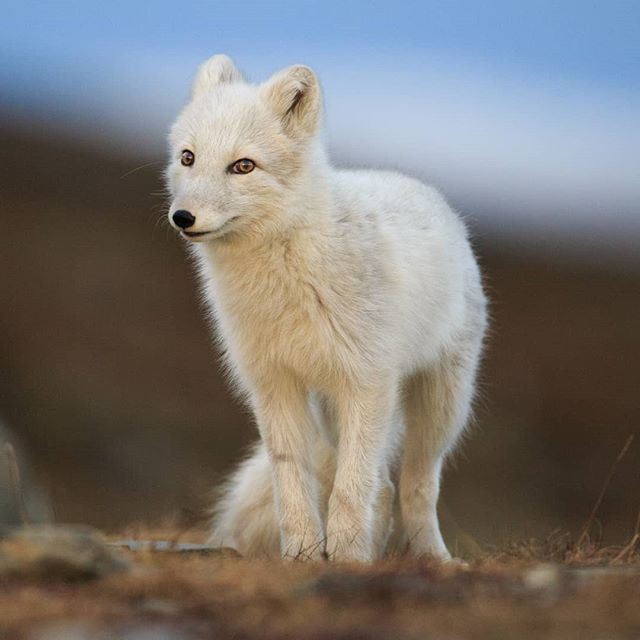

Done generating headmap for  Arctic_fox


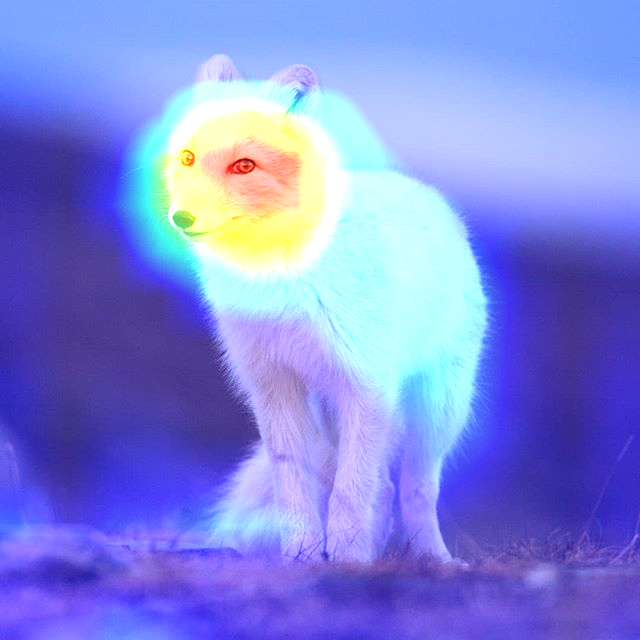

In [13]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

url = 'https://scontent-lht6-1.cdninstagram.com/v/t51.2885-15/sh0.08/e35/s640x640/67096206_152944595853833_7890601765204304502_n.jpg?_nc_ht=scontent-lht6-1.cdninstagram.com&_nc_cat=105&oh=462a420176ae50ee022b9144dbc25868&oe=5E747C2C&ig_cache_key=MjEwNDU5NjM0ODQ3MDMzODIzMQ%3D%3D.2'

img = url_to_image(url)

#Resize the heatmap
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

#Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)

#Apply heatmap to the Image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#Apply heatmap intensity factor. The intensity factor gives us the color scheme of the image 
hmap_intens_fac = 0.8
hmap_img = heatmap * hmap_intens_fac + img

#passing the ouput images to another variable for temporaly storage. Note the number is change after every image has been worked on that is img1, img2, img2....
#and img1 is passed to _img1_ , img2 passed to _img2_ and so on for the n number of images you will like to test
img3 = hmap_img

#category or class of the image that was predicted in this case (golden_retriever)     
category = pedections.loc[0,'category']

print("Done generating headmap for ", category )

#Ouputing the image that the heatmap have been applied to without storing it
cv2_imshow(hmap_img)



This is the image converted to its original form


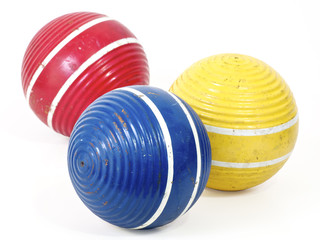

In [0]:
#original image 
url = 'https://t4.ftcdn.net/jpg/00/22/17/43/240_F_22174358_JQR37D8W74DYqRnCsCmKzgyBLZnWZypi.jpg'
img = url_to_image(url)

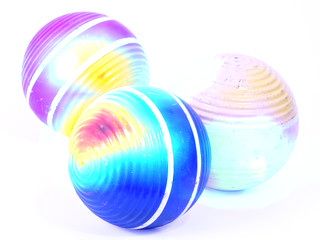

In [0]:
#Image that heatmap have been applied to
_img2_ = img2

cv2_imshow(_img2_)


This is the image converted to its original form


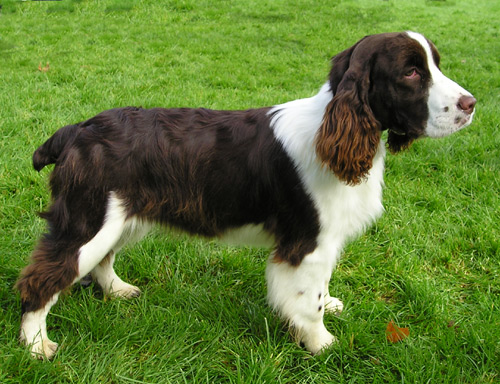

In [0]:
url = 'https://caninebreeds.net/wp-content/uploads/2013/08/EnglishSpringerSpan2_wb.jpg'
img = url_to_image(url)

<h3>End of Tutorial!</h3>

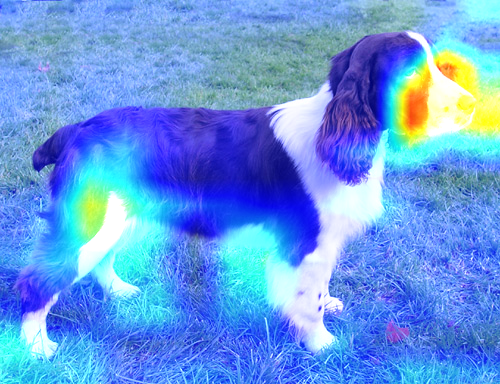

In [0]:
#Image that heatmap have been applied to
_img1_ = img1

cv2_imshow(_img1_)

<h3>Conclusion</h3>
<p>From the above tutorial we have learned that
<ul> 
<li>Heatmaps are applied to the important parts of an object(image) that helps to determine the class of that object as we can see in the above samples. Look at the heatmap applied on the face of the dog you will see that the face is probably one of the most important parts that played in the classification of the dog and it also shows that the imagenet model was well trained with good and clear images.</li>
<li>Before we can pass our image to the model for prediction, we have to resize and preprocess it because <code>tf.keras</code> works but with image batches which os not suitable for our model so we pass it <strong>VGG16</strong> <code>preprocess_input()</code> function.</li>
<li>Also that, after our image has been processed, it is passed now to the model for prediction and application of the heatmap to the image.</li>
</ul>
Hope you enjoyed this tutorial. Thank you for reading it. 
<h3>End of Tutorial!</h3>
</p>